In [2]:
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras_balanced_batch_generator import make_generator

pd.set_option("display.precision", 2)
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import random
import math
from numpy.linalg import inv

from imblearn.over_sampling import RandomOverSampler
from helpers import (ordinal_to_label, digitize, plot_confusion_matrix, plot_model_history,
                     label_to_one_hot_like, one_hot_like_to_label, plot_cm_matrix)

In [3]:
np.set_printoptions(precision=2)
plt.rcParams["figure.figsize"] = (10, 10)

### load data

In [4]:
df = pd.read_pickle("./all_features_120s.pkl")
df.head()

combined_eye_closure  left_image_eye_closure  \
filename frame                                                 
001_1_a  0                      0.26                    0.25   
         1                      0.27                    0.22   
         2                      0.27                    0.23   
         3                      0.27                    0.22   
         4                      0.26                    0.22   

                right_image_eye_closure  combined_eye_state  \
filename frame                                                
001_1_a  0                         0.28                   0   
         1                         0.31                   0   
         2                         0.32                   0   
         3                         0.32                   0   
         4                         0.31                   0   

                left_image_eye_state  right_image_eye_state  subject_id  \
filename frame                                                            
001_1_a  0                         0                      0           1   
         1                         0                      0           1   
         2                         0                      0           1   
         3                         0                      0           1   
         4                         0                      0           1   

                session_id  session_type  num_blinks  mean_blink_length  \
filename frame                                                            
001_1_a  0               1             0           0                0.0   
         1               1             0           0                0.0   
         2               1             0           0                0.0   
         3               1             0           0                0.0   
         4               1             0           0                0.0   

                mean_opening_velocity  mean_closing_velocity  \
filename frame                                                 
001_1_a  0                        0.0                    0.0   
         1                        0.0                    0.0   
         2                        0.0                    0.0   
         3                        0.0                    0.0   
         4                        0.0                    0.0   

                karolinska_response_nearest_interpolation  \
filename frame                                              
001_1_a  0                                              6   
         1                                              6   
         2                                              6   
         3                                              6   
         4                                              6   

                karolinska_response_linear_interpolation  
filename frame                                            
001_1_a  0                                             6  
         1                                             6  
         2                                             6  
         3                                             6  
         4                                             6

In [5]:
# columns
print(df.columns)

Index(['combined_eye_closure', 'left_image_eye_closure',
       'right_image_eye_closure', 'combined_eye_state', 'left_image_eye_state',
       'right_image_eye_state', 'subject_id', 'session_id', 'session_type',
       'num_blinks', 'mean_blink_length', 'mean_opening_velocity',
       'mean_closing_velocity', 'karolinska_response_nearest_interpolation',
       'karolinska_response_linear_interpolation'],
      dtype='object')


### train and test split

In [6]:
# filter out alcohol sessions
unique_indices = list(
    filter(lambda x: not "a" in x,
           df.index.get_level_values('filename').unique()))
subjects = list(set([filename.split("_")[0] for filename in unique_indices]))
random.shuffle(subjects)

test_size = .2
split_index = math.ceil(test_size * len(subjects))
test_subjects = subjects[:split_index]
train_subjects = subjects[split_index:]
val_subjects = train_subjects[:2]
train_subjects = train_subjects[2:]
print(test_subjects, train_subjects, val_subjects)


['004', '009'] ['008', '003', '005', '014', '011'] ['002', '001']


In [7]:
train_subjects = ["001", "002", "003", "004", "009"]
val_subjects = ["005", "008"]
test_subjecst = ["011", "014"]

In [8]:
# create boolean index mask
test_subject_mask = df.index.to_frame().filename.str.contains(
    "|".join(test_subjects))
train_subject_mask = df.index.to_frame().filename.str.contains(
    "|".join(train_subjects))
val_subject_mask = df.index.to_frame().filename.str.contains(
    "|".join(val_subjects))

In [9]:
test_df = df[test_subject_mask]
test_df = test_df.copy()
test_df = test_df[test_df["session_type"] != 0]
test_df = test_df.dropna()
#test_df = test_df.sample(frac=1)
# print(len(test_df))

train_df = df[train_subject_mask]
train_df = train_df.copy()
train_df = train_df[train_df["session_type"] != 0]
train_df = train_df.dropna()
#treain_df = train_df.sample(frac=1)
#print(len(train_df))

val_df = df[val_subject_mask]
val_df = val_df.copy()
val_df = val_df[val_df["session_type"] != 0]
val_df = val_df.dropna()
#treain_df = train_df.sample(frac=1)
#print(len(train_df))

feature_columns = [
    'num_blinks', 'mean_blink_length', 'mean_opening_velocity',
    'mean_closing_velocity'
]
target_columns = ["karolinska_response_linear_interpolation"]

X_train = train_df[feature_columns].astype(float).to_numpy()
X_test = test_df[feature_columns].astype(float).to_numpy()
X_val = val_df[feature_columns].astype(float).to_numpy()

y_train = train_df[target_columns].astype(float).to_numpy()
y_test = test_df[target_columns].astype(float).to_numpy()
y_val = val_df[target_columns].astype(float).to_numpy()

print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (1336295, 4)
X_test.shape = (463008, 4)
y_train.shape = (1336295, 1)
y_test.shape = (463008, 1)


In [10]:
# set labels to [0, 8]
y_train = y_train - 1
y_test = y_test - 1
y_val = y_val - 1

In [11]:
# normalize
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train = norm_layer(X_train)
X_test = norm_layer(X_test)
X_val = norm_layer(X_val)

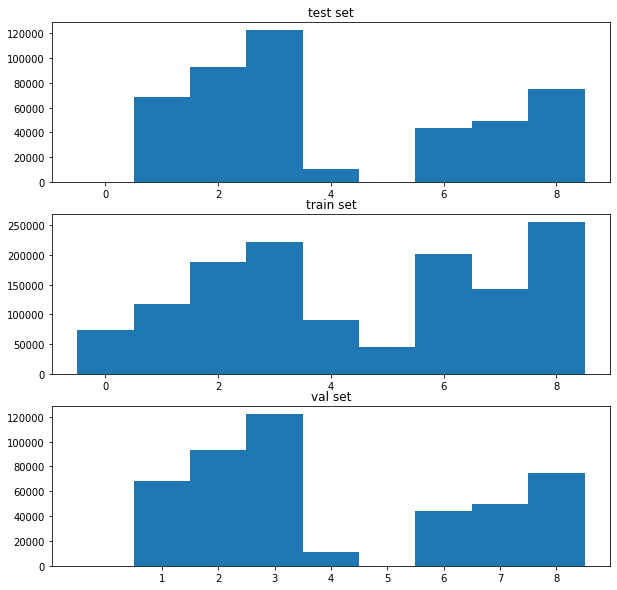

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
bins = [x - .5 for x in range(0, 10)]
ax1.hist(y_test, bins=bins)
ax1.set_title("test set")
ax2.hist(y_train, bins=bins)
ax2.set_title("train set")
ax3.hist(y_test, bins=bins)
ax3.set_title("val set")

plt.xticks(range(1, 9))
plt.show()

In [16]:
def casted_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(tf.add(y_pred, 0.5), tf.int32)
    return tf.divide(
        tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.int32)),
        tf.size(y_true))

In [17]:
for name, weigth in zip(feature_columns, regression_model.weights[0].numpy()):
    print(name, weigth)

print("bias", regression_model.weights[1].numpy())

NameError: name 'regression_model' is not defined

In [15]:
print(f"Test MAE: {results[0]}")
print(f"Test Accuracy {results[1]}")

NameError: name 'results' is not defined

Confusion matrix, without normalization


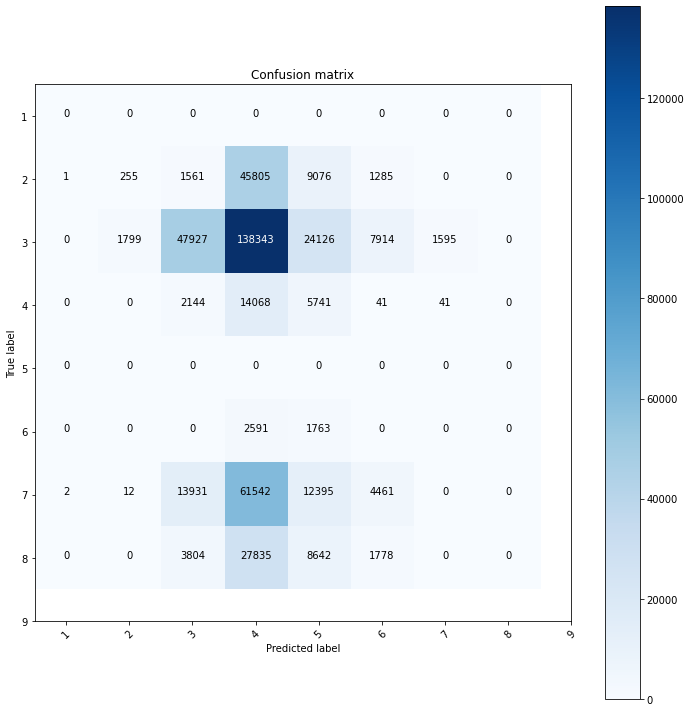

In [43]:
plot_cm_matrix(regression_model, X_test, y_test, output_kind="digitize")

### closed form solution
$$
\beta = (X X^T)^{-1} X^T y
$$

In [18]:
def closed_form_ols(X, y):
    # calculate coefficients using closed-form solution
    coeffs = inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)
    return coeffs


In [19]:
￼
# normalize
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train = norm_layer(X_train)
X_test = norm_layer(X_test)
X_val = norm_layer(X_val)
#original dataset with bias feature
bias_ones = np.ones(shape=(len(X_train)))
X_train_with_bias = np.c_[ X_train.numpy(), bias_ones]

coeffs_with_bias = closed_form_ols(X_train_with_bias, y_train)
# print(coeffs_with_bias)
for name, weigth in zip(feature_columns + ["bias"], coeffs_with_bias):
    print(name, weigth[0])


SyntaxError: invalid character in identifier (<ipython-input-19-175a858c2124>, line 1)

In [20]:
# create model from ols weights
BATCH_SIZE = 256
loss = "mae"
optimizer = "sgd"

closed_form_model = Sequential()
closed_form_model.add(Dense(1, input_dim=X_train.shape[-1]))
closed_form_model.compile(loss=loss,
                         optimizer=optimizer,
                         metrics=[casted_accuracy, loss])
closed_form_model.summary()

# set weights
closed_form_model.set_weights([coeffs_with_bias[:-1], coeffs_with_bias[-1]])

# evaluate and save model
results = closed_form_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)
model_name = f"./models/closed_form_model_{int(results[-1] * 100)}"
print(model_name)
closed_form_model.save(
    model_name
)


# plot confusion matrix
plot_cm_matrix(closed_form_model, X_test, y_test, output_kind="digitize")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


NameError: name 'coeffs_with_bias' is not defined